# Economic Activity

Plotting data for the Economic Activity in the US

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# path for the folder "project"
path = "C:\\Users\\pedro\\OneDrive\\NYU\\CSS\\II. Data Skills\\project"
os.chdir(path)

# colors
colors = [
    '#1B4F72','#D35400','#16A05D','#DC2F1D','#3498DB','#9C9C9C','#F39C12','#28B463','#EC7063','#F1C40F',  # custom
    '#641E16','#7B241C','#922B21','#A93226','#C0392B','#CD6155','#D98880','#E6B0AA','#F2D7D5','#F9EBEA',  # dark red
    '#78281F','#943126','#B03A2E','#CB4335','#E74C3C','#EC7063','#F1948A','#F5B7B1','#FADBD8','#FDEDEC',  # red
    '#154360','#1A5276','#1F618D','#2471A3','#2980B9','#5499C7','#7FB3D5','#A9CCE3','#D4E6F1','#EAF2F8',  # dark blue
    '#1B4F72','#21618C','#2874A6','#2E86C1','#3498DB','#5DADE2','#85C1E9','#AED6F1','#D6EAF8','#EBF5FB',  # blue
    '#145A32','#196F3D','#1E8449','#229954','#27AE60','#52BE80','#7DCEA0','#A9DFBF','#D4EFDF','#E9F7EF',  # dark green
    '#0B5345','#0E6655','#117A65','#138D75','#16A085','#45B39D','#73C6B6','#A2D9CE','#D0ECE7','#E8F6F3',  # green
    '#6E2C00','#873600','#A04000','#BA4A00','#D35400','#DC7633','#E59866','#EDBB99','#F6DDCC','#FBEEE6',  # dark orange
    '#784212','#935116','#AF601A','#CA6F1E','#E67E22','#EB984E','#F0B27A','#F5CBA7','#FAE5D3','#FDF2E9',  # orange
    '#7D6608','#9A7D0A','#B7950B','#D4AC0D','#F1C40F','#F4D03F','#F7DC6F','#F9E79F','#FCF3CF','#FEF9E7',  # yellow
    '#626567','#797D7F','#909497','#A6ACAF','#BDC3C7','#CACFD2','#D7DBDD','#E5E7E9','#F2F3F4','#F8F9F9']  # gray


plt.style.use('seaborn-bright')
plt.rcParams['figure.dpi'] = 200 # high quality figure.
%matplotlib inline

## Functions

Writting functions to transform and plot data.  
For more details about the functions, take a look at the `charts_inflation` notebook.

In [2]:
# creating function to calculate percent changes.

def compute_change(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates yoy changes for different groups in the Data Frame.
    ---
    paramns:
        x: pandas dataframe with date, series_id and values columns.
        n: int representing the percent change period. (n=12 for YoY, n=1 for MoM)
        dt: dates column name
        series: series_id column name
        value: values column name
    
    returns: pandas data frame with yoy changes by group in the original value column.
    """
    return (x
            .sort_values(dt)
            .set_index([dt, series])
            .groupby(pd.Grouper(level = series))[value]
            .pct_change(periods = n)
            .dropna()
            .reset_index()
            .eval(f"{value} = {value}*100"))


In [3]:
# function to calculate monthly annual change rates.

def saar(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates monthly annual rate changes
    ---
    paramns:
        x: pandas dataframe with date, series id and values columns
        n: [int] Number of months
        dt: [str] dates column name
        series: [str] series_id column name
        value: [str] values column name
    
    returns: pandas series with yoy changes by group.
    """
    x = (x
         .sort_values(dt)
         .set_index(dt)
         .groupby(series)[value]
         .rolling(n)
         .mean()
         .dropna()
         .reset_index())
    
    x = (x
         .sort_values(dt)
         .set_index([dt, series])
         .groupby(pd.Grouper(level = series))[value]
         .pct_change(periods = n)
         .dropna()
         .reset_index()
         .eval(f"{value} = {value}+1")
         .eval(f"{value} = ({value}**{12/n} -1) * 100"))
      
    return x


In [4]:
# function to plot time series data.

def ts_plot(df, df_map, start_date, title, ylab,
            fig_size = (12,6), legend_loc = "upper left",
            plot_recession = True, plot_zero = True,
            xmargin = 0.01, ymargin = 0.04,
            y_major_loc = 2, y_minor_loc = 2,
            x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # last observation
    last = df.groupby("series_id")["date"].max().reset_index()
    last = pd.merge(last,df,how="left", on=["series_id","date"])
    
    # line plot using seaborn and annotation
    for i in range(len(df_map)):
    
        sns.lineplot(
            data=df[df["series_id"]==df_map.loc[i][0]], #filter series
            x="date", y="value",
            color=df_map.loc[i][1], # map color
            alpha = df_map.loc[i][2], # map alpha
            ax=ax, legend=False)
    
        if df_map.loc[i][3] == True:
            ax.annotate(text = round(last.loc[last["series_id"] == df_map.loc[i][0], "value"].values[0],1),
                        xy = (last.loc[last["series_id"] == df_map.loc[i][0], "date"],
                              last.loc[last["series_id"] == df_map.loc[i][0], "value"]),
                        xycoords = "data", xytext = (1,0), textcoords="offset points",
                        color = df_map.loc[i][1], alpha = df_map.loc[i][2],
                        size='small', stretch="ultra-expanded",weight="semibold")
    
    # adding legend
    ax.legend(list(df_map["series_id"].values), 
        loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ylab, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax.spines['right'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date),pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = last["date"].dt.strftime("%B, %Y").max()
    ax.set_xlabel(f"last update: {sub}",labelpad = 8, loc="center")
    
    return fig, ax


In [5]:
# function to plot time series data with two y-axis.
def dual_ts_plot(df, series1, series2, start_date, title, ly_label, ry_label,
                 fig_size = (12,6), legend_loc = "upper left",
                 plot_recession = True, plot_zero = True,
                 xmargin = 0.01, ymargin = 0.04,
                 y_major_loc = 2, y_minor_loc = 2,
                 x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # inside the function:
    data1 = df[df["series_id"]==series1].copy()
    data2 = df[df["series_id"]==series2].copy()
    
    mean1 = np.mean(data1["value"])
    sd1 = np.std(data1["value"])
    
    mean2 = np.mean(data2["value"])
    sd2 = np.std(data2["value"])
    
    data2["value"] = ((data2["value"] - mean2)/sd2)*sd1 + mean1
    
    # line plot using seaborn
    sns.lineplot(data=data1,
                 x="date", y="value",
                 color=colors[0], ax=ax, legend=False)
    
    sns.lineplot(data=data2,
                 x="date", y="value", color=colors[1], ax=ax, legend=False)
    
    ax2 = ax.twinx()
    
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(sd2*((y1-mean1)/sd1)+mean2, sd2*((y2-mean1)/sd1)+mean2)
        
    # adding legend
    ax.legend([ly_label, ry_label],
              loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ly_label, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    ax2.set_ylabel(ry_label, size='medium')
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax2.spines['top'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date), pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = df["date"].max().strftime("%B, %Y")
    ax.set_xlabel(f"last update: {sub}", labelpad = 8, loc="center")
    
    return fig, ax



## Importing Data

In [6]:
# BEA data
gdp = pd.read_parquet("data\\activity\\data_bea_gdp.parquet")
pce = pd.read_parquet("data\\activity\\data_bea_pce.parquet")
income = pd.read_parquet("data\\activity\\data_bea_income.parquet")

## US GDP

In [31]:
# Real GDP
real_gdp = (gdp[
    (gdp["LineDescription"]=="Gross domestic product") &
    (gdp["METRIC_NAME"]=="Chained Dollars")].copy())

real_gdp["series_id"] = real_gdp["series_id"].replace("T10106_A191RX","Real GDP (Bi USD)")
real_gdp["value"] = real_gdp["value"]/1000

real_gdp.tail()

,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
298,Real GDP (Bi USD),2021-09-01,19672.594,Gross domestic product,Chained Dollars,Level
299,Real GDP (Bi USD),2021-12-01,20006.181,Gross domestic product,Chained Dollars,Level
300,Real GDP (Bi USD),2022-03-01,19924.088,Gross domestic product,Chained Dollars,Level
301,Real GDP (Bi USD),2022-06-01,19895.271,Gross domestic product,Chained Dollars,Level
302,Real GDP (Bi USD),2022-09-01,20021.721,Gross domestic product,Chained Dollars,Level


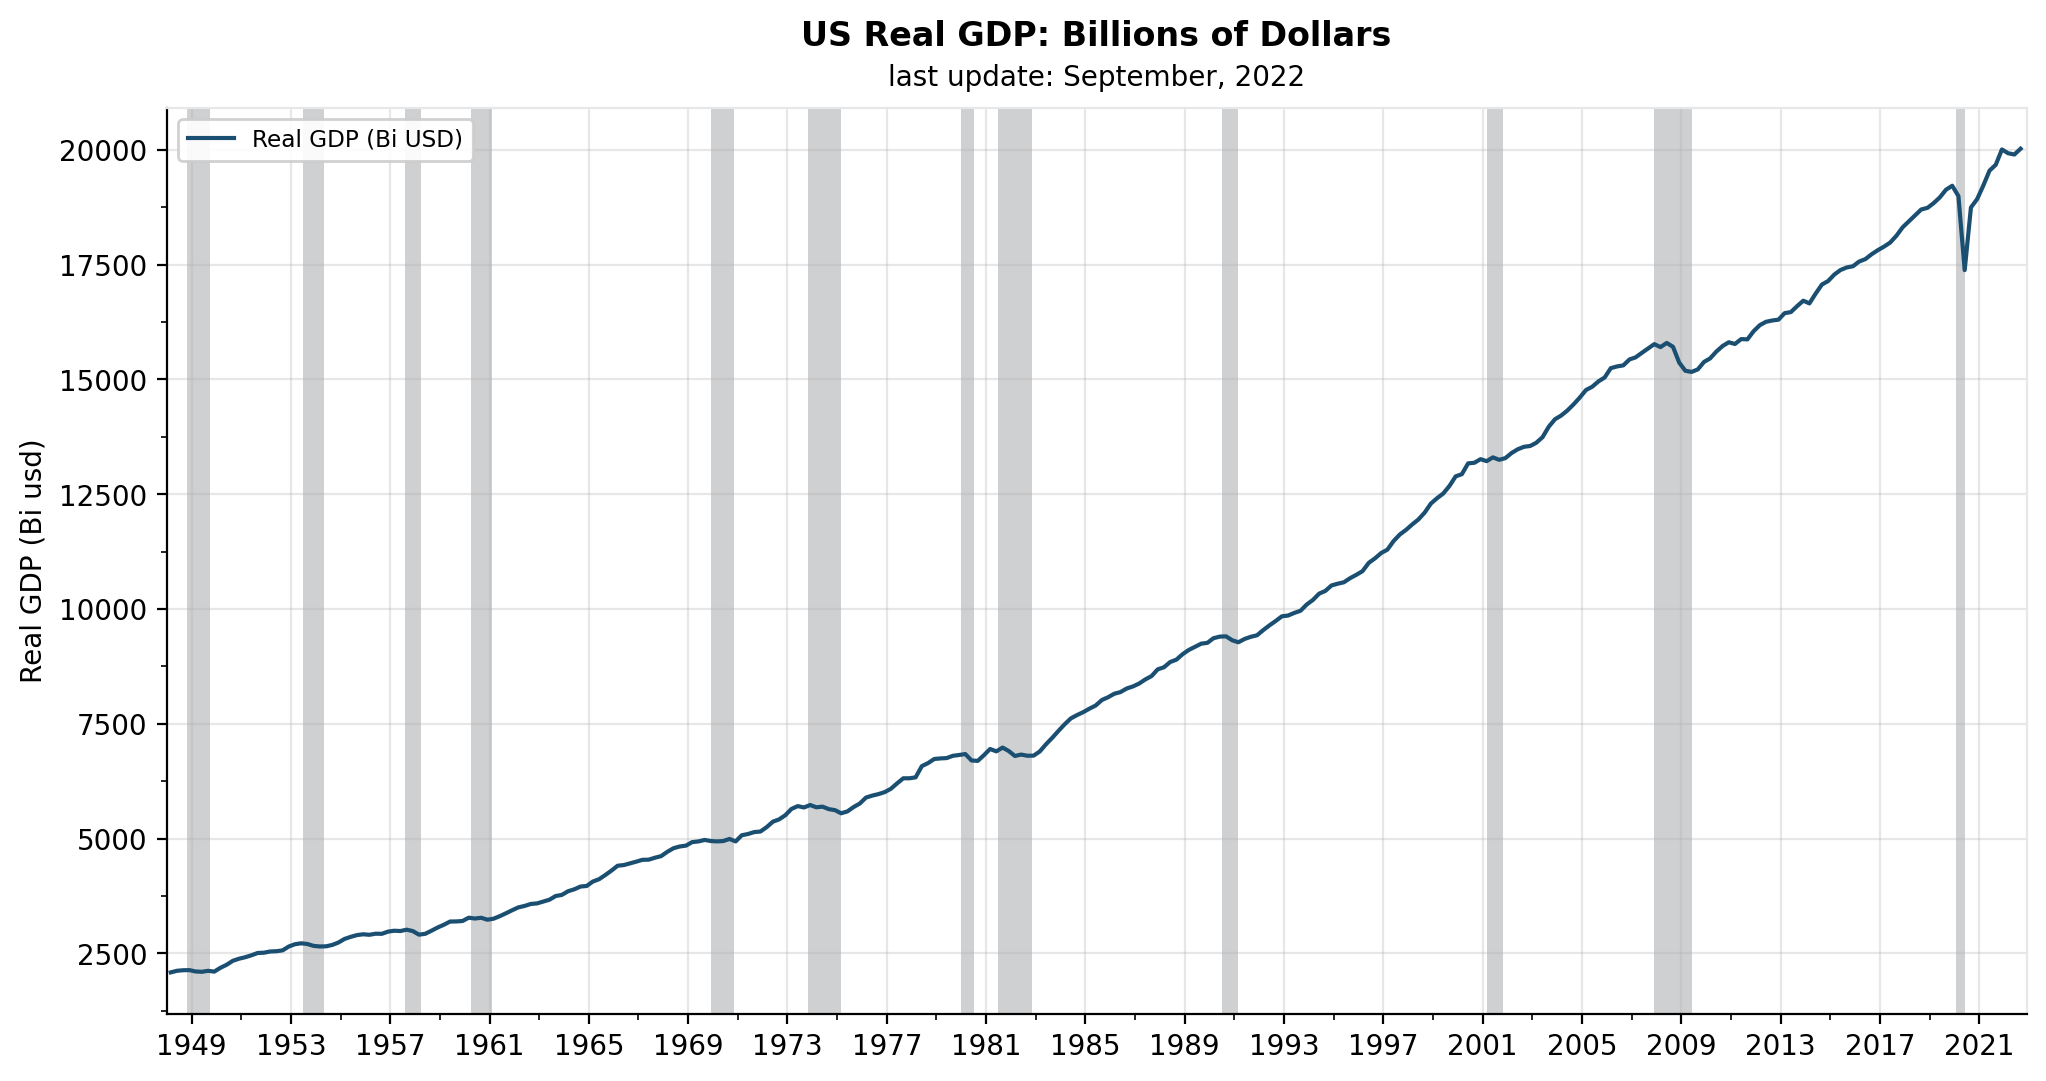

In [32]:
# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Real GDP (Bi USD)'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = real_gdp[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1948-01-01",
                  title ='US Real GDP: Billions of Dollars',
                  ylab='Real GDP (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2500, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

In [81]:
# Contribution for the Real GDP Quarterly Change
gdp_contribution = gdp[(gdp["METRIC_NAME"]=="Quantity Contributions")].copy()

gdp_contribution = gdp_contribution[
    gdp_contribution["LineDescription"].isin(["Personal consumption expenditures",
                                              "Fixed investment",
                                              "Change in private inventories",
                                              "Net exports of goods and services",
                                              "Government consumption expenditures and gross investment"])]

gdp_contribution["series_id"] = (
    gdp_contribution["series_id"]
    .replace(["T10102_DPCERY","T10102_A007RY","T10102_A019RY","T10102_A014RY","T10102_A822RY"],
             ["Consumption","Investment","Net Exports","Inventories","Government"] ))

gdp_contribution.sort_values("date").head()

,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
302,Consumption,1947-06-01,4.30,Personal consumption expenditures,Quantity Contributions,Level
2114,Investment,1947-06-01,-1.47,Fixed investment,Quantity Contributions,Level
4228,Net Exports,1947-06-01,-0.68,Net exports of goods and services,Quantity Contributions,Level
3926,Inventories,1947-06-01,-3.25,Change in private inventories,Quantity Contributions,Level
6342,Government,1947-06-01,0.03,Government consumption expenditures and gross ...,Quantity Contributions,Level


In [82]:
# reshaping data:
gdp_contribution = (
    pd.pivot_table(
        gdp_contribution[["date","series_id","value"]],
        values="value", columns="series_id", index="date")
    .reset_index()
    .rename_axis(None,axis=1)
)

gdp_contribution["GDP"] = (gdp_contribution["Consumption"]+
                           gdp_contribution["Government"]+
                           gdp_contribution["Inventories"]+
                           gdp_contribution["Investment"]+
                           gdp_contribution["Net Exports"])

gdp_contribution = gdp_contribution[gdp_contribution["date"]>="2002"]
gdp_contribution.head()

,date,Consumption,Government,Inventories,Investment,Net Exports,GDP
219,2002-03-01,0.58,1.29,2.74,-0.60,-0.67,3.34
220,2002-06-01,1.34,0.58,1.30,-0.06,-0.66,2.50
221,2002-09-01,1.86,0.39,0.04,-0.10,-0.57,1.62
222,2002-12-01,1.48,0.57,0.28,-0.30,-1.51,0.52
223,2003-03-01,1.31,0.06,-0.06,0.62,0.15,2.08


In [83]:
# data for contr. Chart:
#contr = headline_contr.copy()
#contr = contr[["date","Core","Food","Energy"]]

#yoy = df_yoy.loc[df_yoy["series_id"]=="CPI (yoy)",["series_id","date","value"]]
#yoy = yoy[yoy["date"]>="2012-03-01"]

# _positive
contr_positive = gdp_contribution.drop(columns = "GDP").copy()
contr_positive.loc[contr_positive["Consumption"] < 0 ,"Consumption"] = 0
contr_positive.loc[contr_positive["Government"] < 0 ,"Government"] = 0
contr_positive.loc[contr_positive["Inventories"] < 0 ,"Inventories"] = 0
contr_positive.loc[contr_positive["Investment"] < 0 ,"Investment"] = 0
contr_positive.loc[contr_positive["Net Exports"] < 0 ,"Net Exports"] = 0

# _negative
contr_negative = gdp_contribution.drop(columns = "GDP").copy()
contr_negative.loc[contr_negative["Consumption"] >= 0 ,"Consumption"] = 0
contr_negative.loc[contr_negative["Government"] >= 0 ,"Government"] = 0
contr_negative.loc[contr_negative["Inventories"] >= 0 ,"Inventories"] = 0
contr_negative.loc[contr_negative["Investment"] >= 0 ,"Investment"] = 0
contr_negative.loc[contr_negative["Net Exports"] >= 0 ,"Net Exports"] = 0

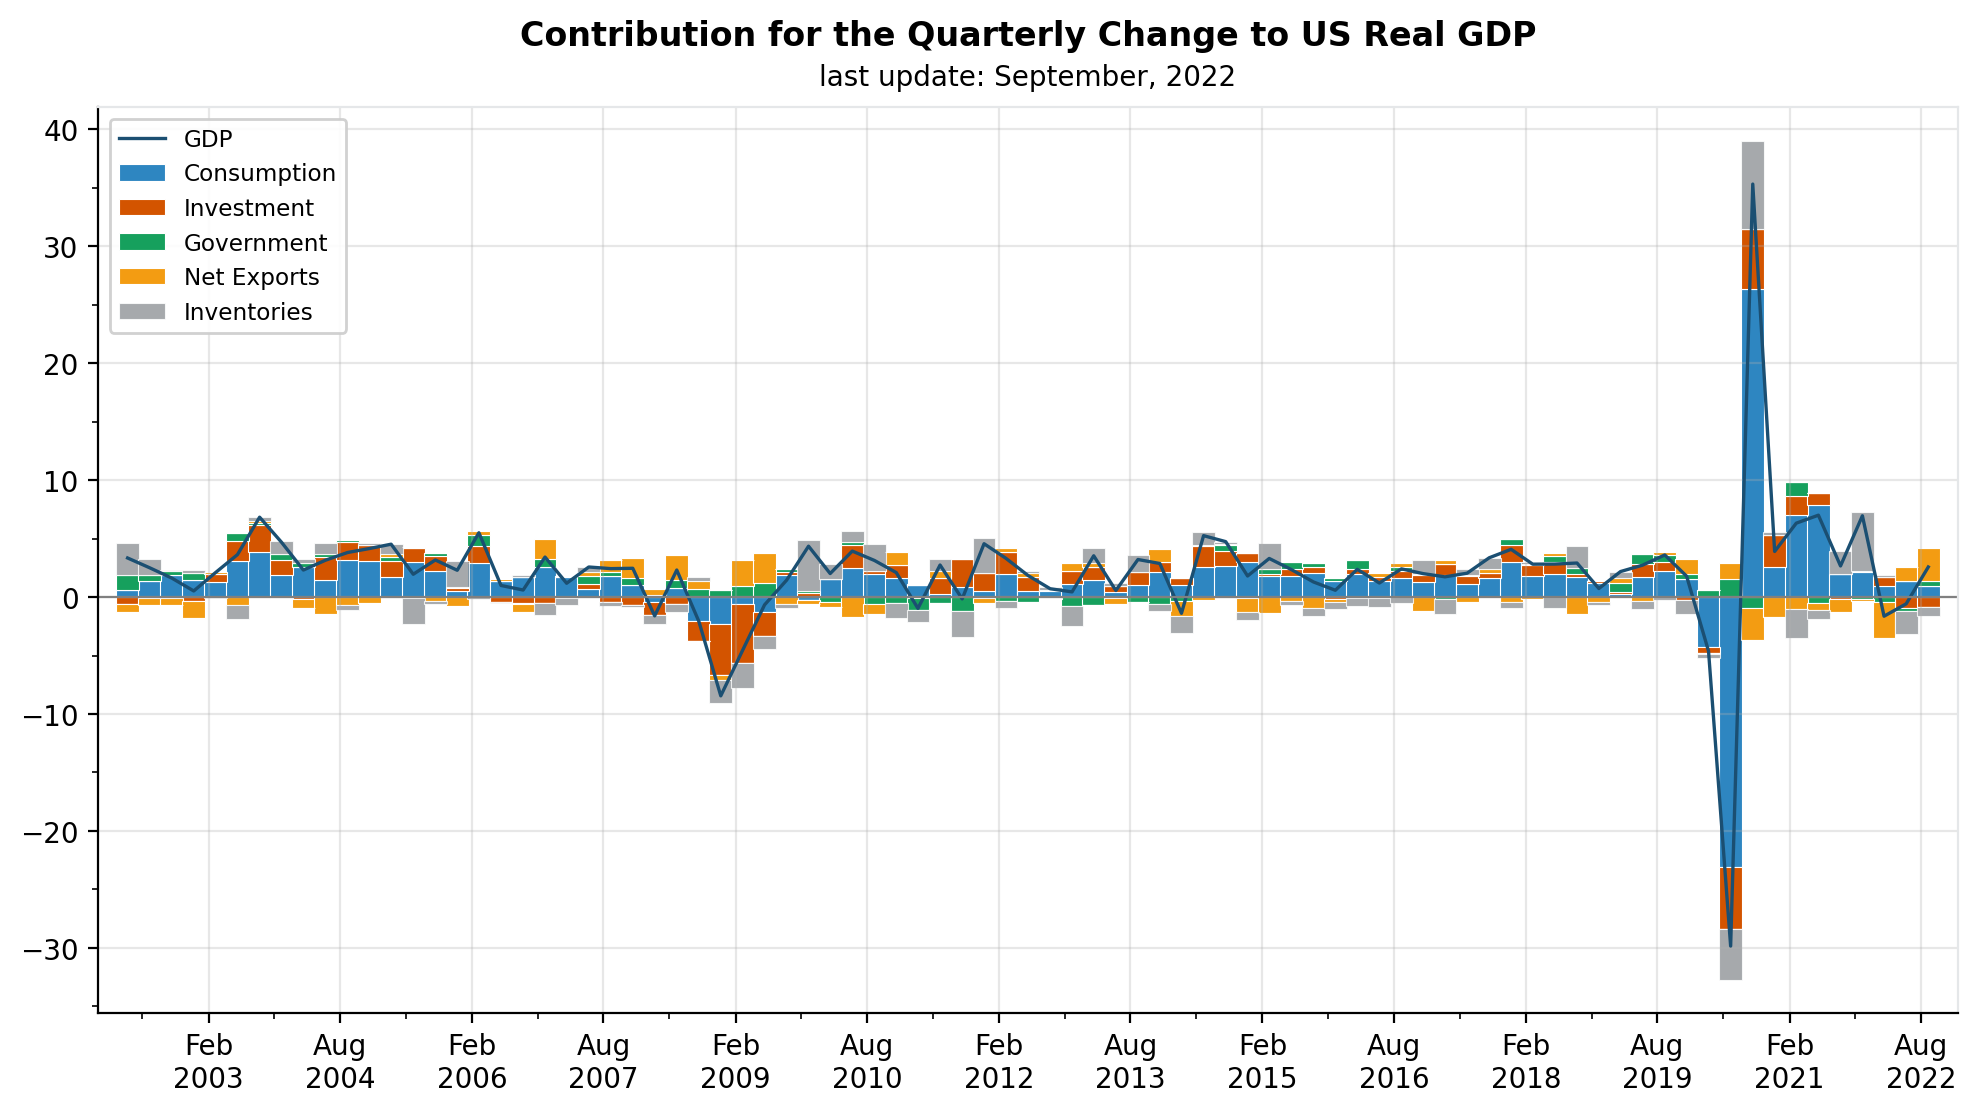

In [94]:
# chart:
#plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(contr_positive["date"], contr_positive["Consumption"],
       width = 95, label="Consumption", color= colors[43], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Investment"], width = 95,
       bottom = contr_positive["Consumption"], label="Investment", color= colors[1], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Government"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"],
       label="Government", color= colors[2], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Net Exports"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"]+contr_positive["Government"],
       label="Net Exports", color= colors[6], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_positive["date"], contr_positive["Inventories"], width = 95,
       bottom = contr_positive["Consumption"]+contr_positive["Investment"]+
       contr_positive["Government"] + contr_positive["Net Exports"],
       label="Inventories", color= colors[102], alpha=0.8,
       edgecolor = 'white', linewidth = 0.4)



# negative values
ax.bar(contr_negative["date"], contr_negative["Consumption"],
       width = 95, label="Consumption", color= colors[43], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Investment"], width = 95,
       bottom = contr_negative["Consumption"], label="Investment", color= colors[1], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Government"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"],
       label="Government", color= colors[2], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Net Exports"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"]+contr_negative["Government"],
       label="Net Exports", color= colors[6], alpha=1,
       edgecolor = 'white', linewidth = 0.4)

ax.bar(contr_negative["date"], contr_negative["Inventories"], width = 95,
       bottom = contr_negative["Consumption"]+contr_negative["Investment"]+
       contr_negative["Government"] + contr_negative["Net Exports"],
       label="Inventories", color= colors[102], alpha=0.8,
       edgecolor = 'white', linewidth = 0.4)

# line
sns.lineplot(data=gdp_contribution,
            x="date", y="GDP",
            color=colors[0], ax=ax, legend=False,linewidth = 1.2)

ax.legend(['GDP','Consumption', 'Investment','Government', 'Net Exports', 'Inventories'], 
    loc='upper left', frameon=True, framealpha=0.9, fontsize='small')

ax.axhline(y=0, color='gray', lw=0.8, label = "_line")

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=9))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(10.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Contribution for the Quarterly Change to US Real GDP', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = contr_positive.loc[contr_positive['date']==max(contr_positive['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

## Personal Consumption Expenditure

In [113]:
#Personal consumption expenditures (PCE)
pce_level = pce[(pce["METRIC_NAME"]=="Chained Dollars") & 
                (pce["LineDescription"]=="Personal consumption expenditures (PCE)")].copy()

pce_level["series_id"] = pce_level["series_id"].replace("T20806_DPCERX","PCE (Bi USD)")
pce_level["value"] = pce_level["value"]/1000

pce_level.tail()

,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
244,PCE (Bi USD),2022-05-01,14093.086,Personal consumption expenditures (PCE),Chained Dollars,Level
245,PCE (Bi USD),2022-06-01,14121.801,Personal consumption expenditures (PCE),Chained Dollars,Level
246,PCE (Bi USD),2022-07-01,14106.749,Personal consumption expenditures (PCE),Chained Dollars,Level
247,PCE (Bi USD),2022-08-01,14148.148,Personal consumption expenditures (PCE),Chained Dollars,Level
248,PCE (Bi USD),2022-09-01,14192.190,Personal consumption expenditures (PCE),Chained Dollars,Level


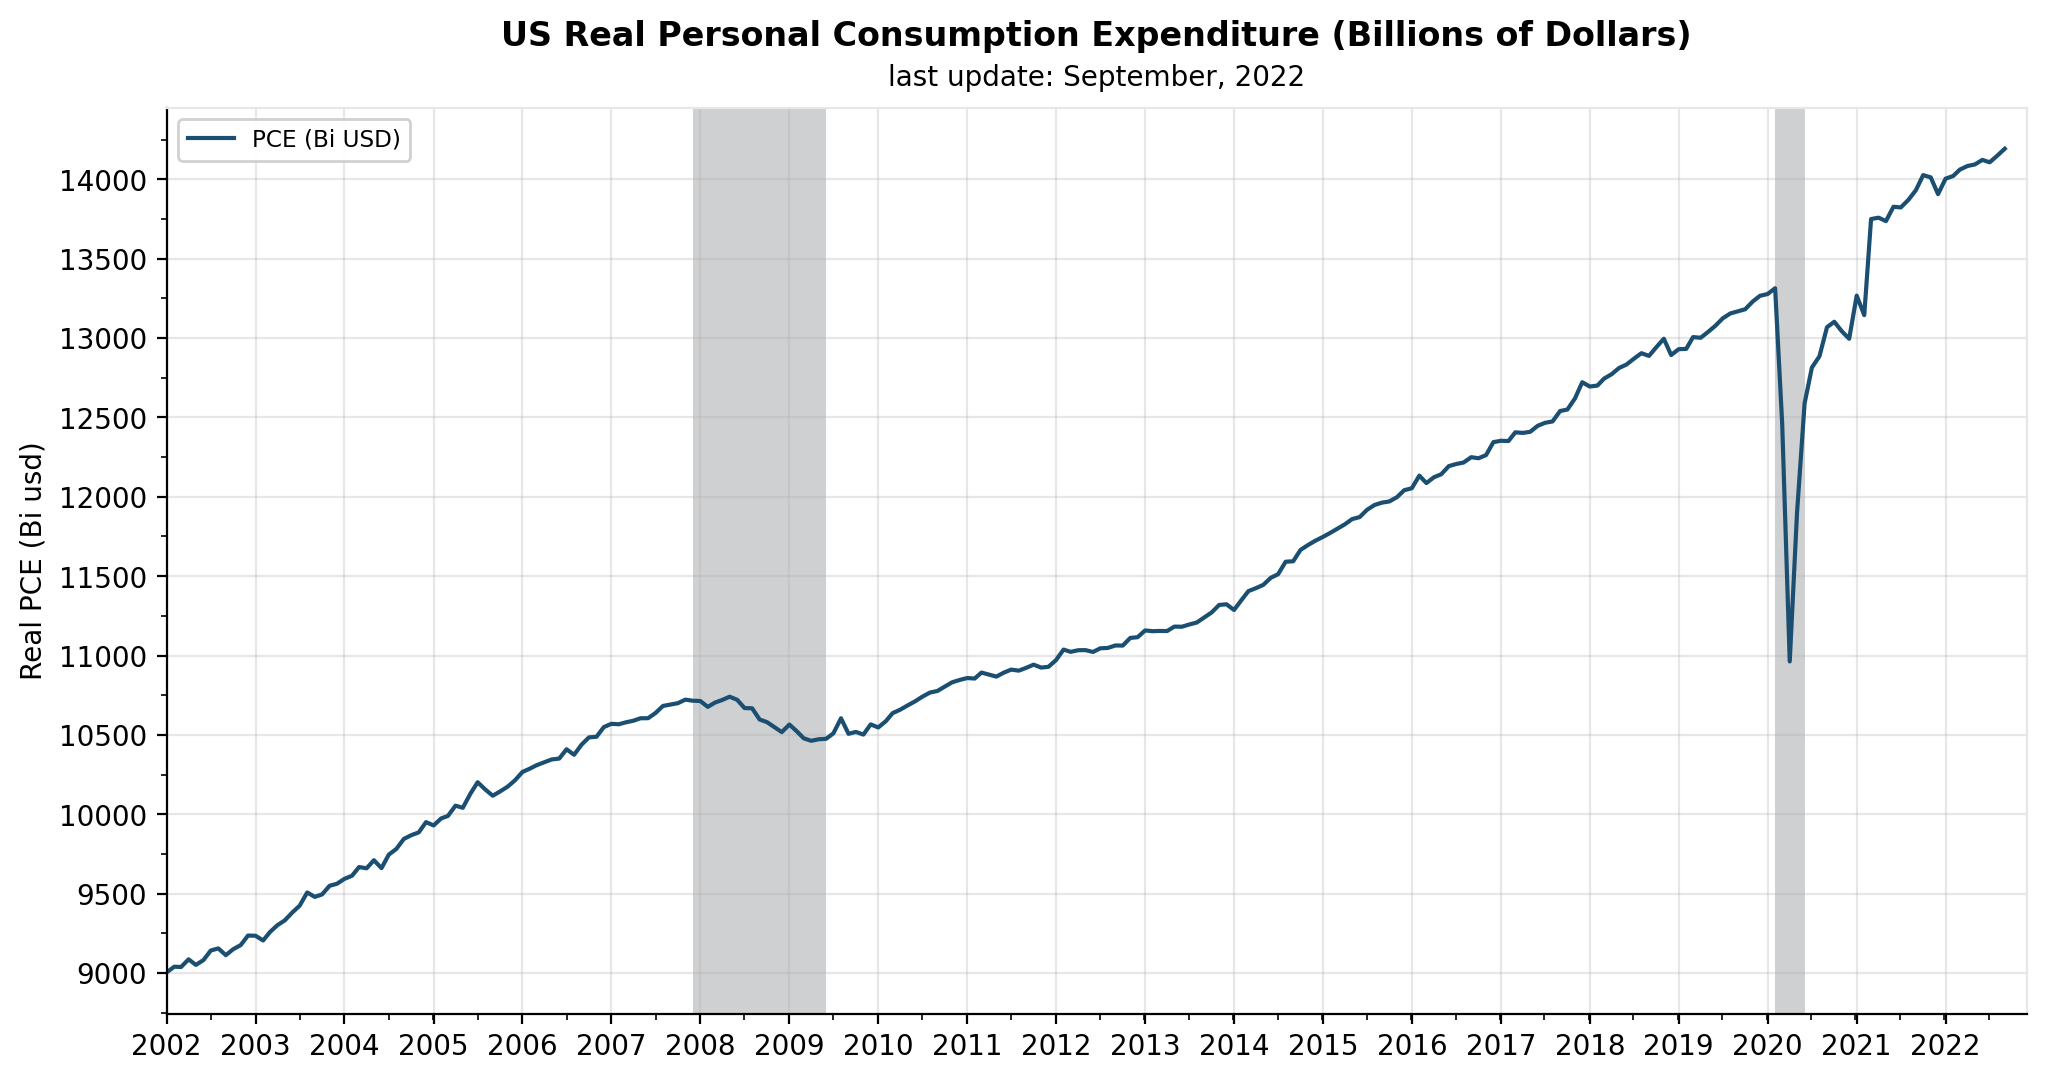

In [114]:
# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['PCE (Bi USD)'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = pce_level[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='US Real Personal Consumption Expenditure (Billions of Dollars)',
                  ylab='Real PCE (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

In [116]:
# Personal Consumption: Services x Goods
pce_comp = pce[(pce["METRIC_NAME"]=="Chained Dollars") & 
                (pce["LineDescription"].isin(["Services","Goods"]))].copy()

pce_comp["series_id"] = (
    pce_comp["series_id"]
    .replace(["T20806_DSERRX","T20806_DGDSRX"],
             ["PCE Services","PCE Goods"])
)

pce_comp["value"] = pce_comp["value"]/1000

pce_comp.sort_values("date").tail()

,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
495,PCE Goods,2022-07-01,5507.505,Goods,Chained Dollars,Level
1243,PCE Services,2022-08-01,8775.794,Services,Chained Dollars,Level
496,PCE Goods,2022-08-01,5505.073,Goods,Chained Dollars,Level
497,PCE Goods,2022-09-01,5527.496,Goods,Chained Dollars,Level
1244,PCE Services,2022-09-01,8798.727,Services,Chained Dollars,Level


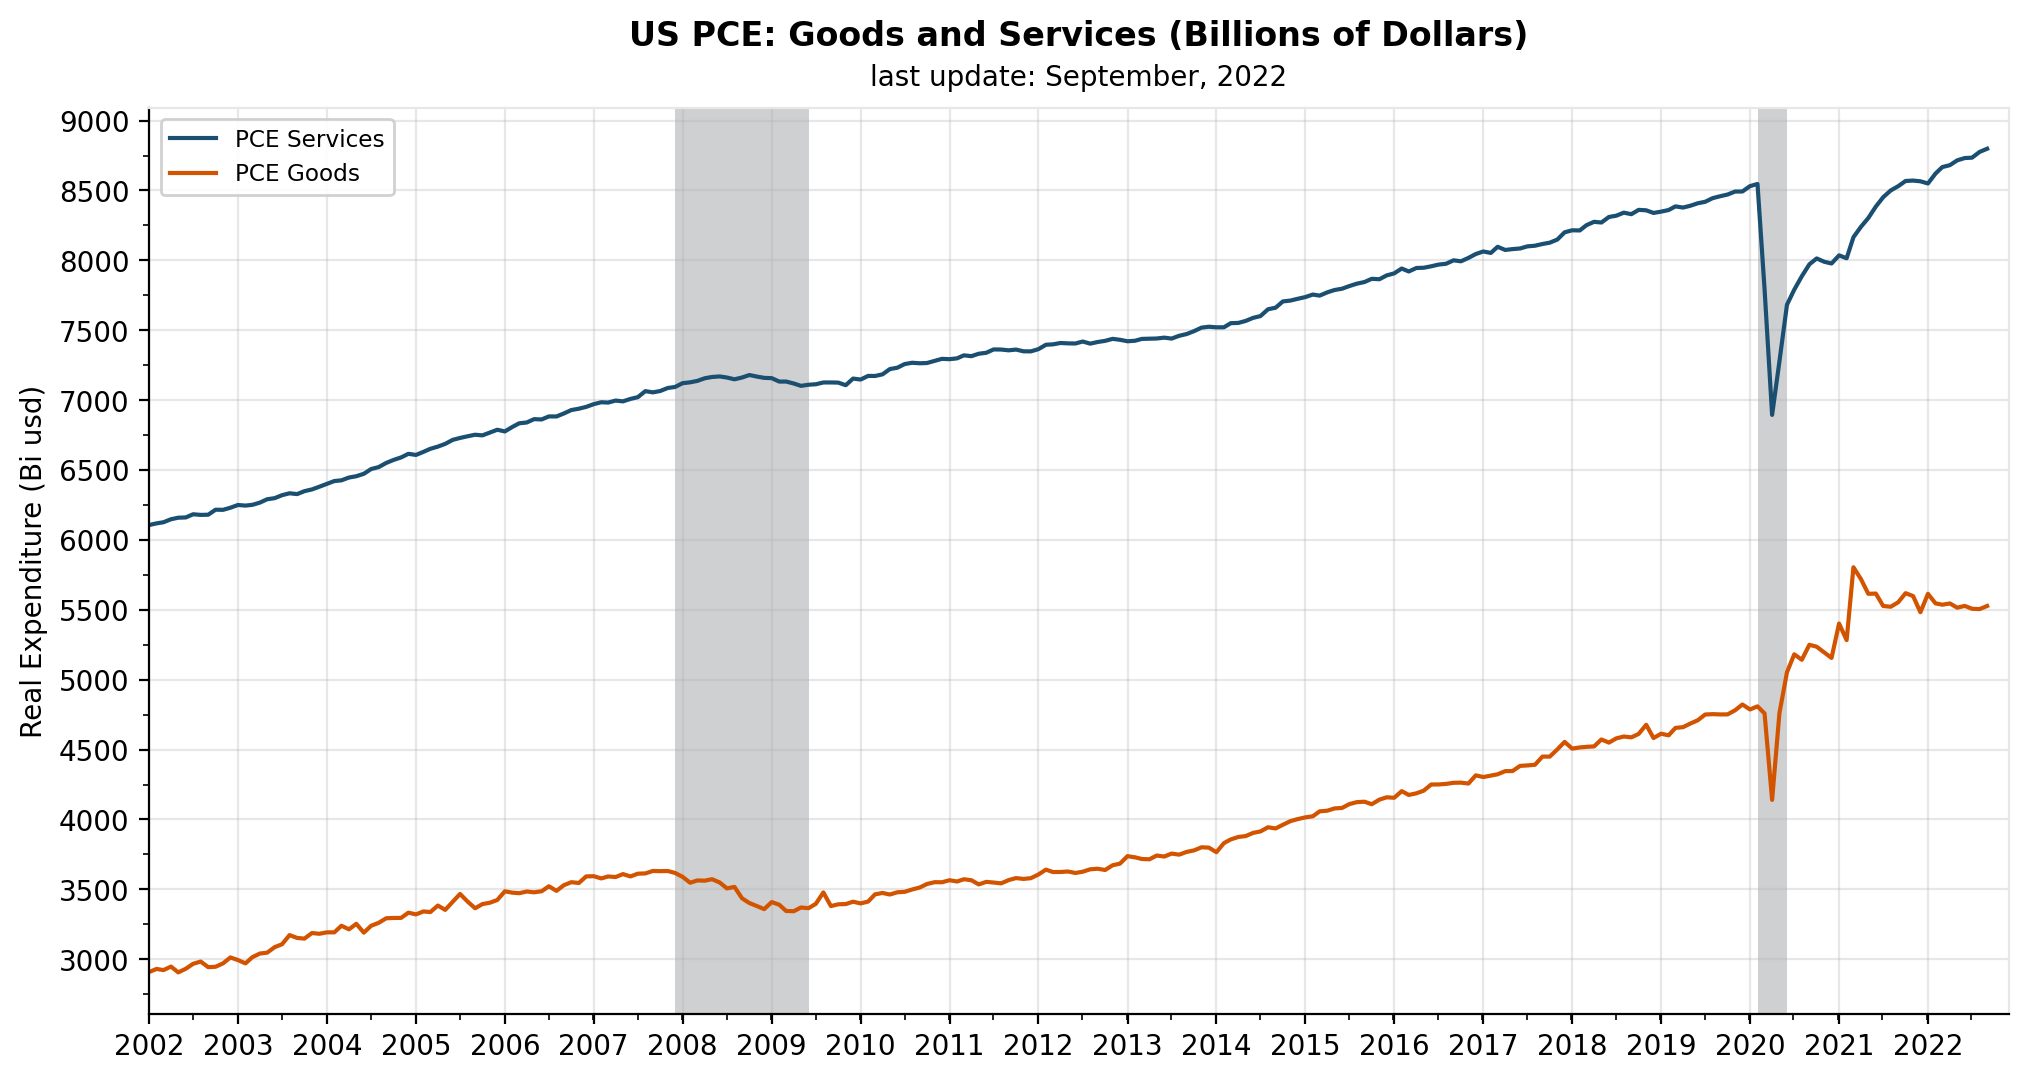

In [117]:
# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["PCE Services","PCE Goods"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[False, False]})

# running function
fig, ax = ts_plot(df = pce_comp[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='US PCE: Goods and Services (Billions of Dollars)',
                  ylab='Real Expenditure (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

## Personal Income

In [126]:
income_level = income[(income["METRIC_NAME"]=="Chained Dollars")].copy()# & 
                #(income["LineDescription"].isin(["Services","Goods"]))].copy()

income_level["series_id"] = (
    income_level["series_id"]
    .replace(["T20600_A067RX","T20600_W875RX"],
             ["Real Personal Income","Real Personal Income ex-Transfers"])
)

income_level["value"] = income_level["value"]/1000

income_level.sort_values("date").tail()


,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
27363,Real Personal Income ex-Transfers,2022-07-01,14557.739,Personal income excluding current transfer rec...,Chained Dollars,Level
28129,Real Personal Income,2022-08-01,15122.945,"Total, billions of chained (2012) dollars",Chained Dollars,Level
27364,Real Personal Income ex-Transfers,2022-08-01,14583.244,Personal income excluding current transfer rec...,Chained Dollars,Level
27365,Real Personal Income ex-Transfers,2022-09-01,14602.566,Personal income excluding current transfer rec...,Chained Dollars,Level
28130,Real Personal Income,2022-09-01,15130.175,"Total, billions of chained (2012) dollars",Chained Dollars,Level


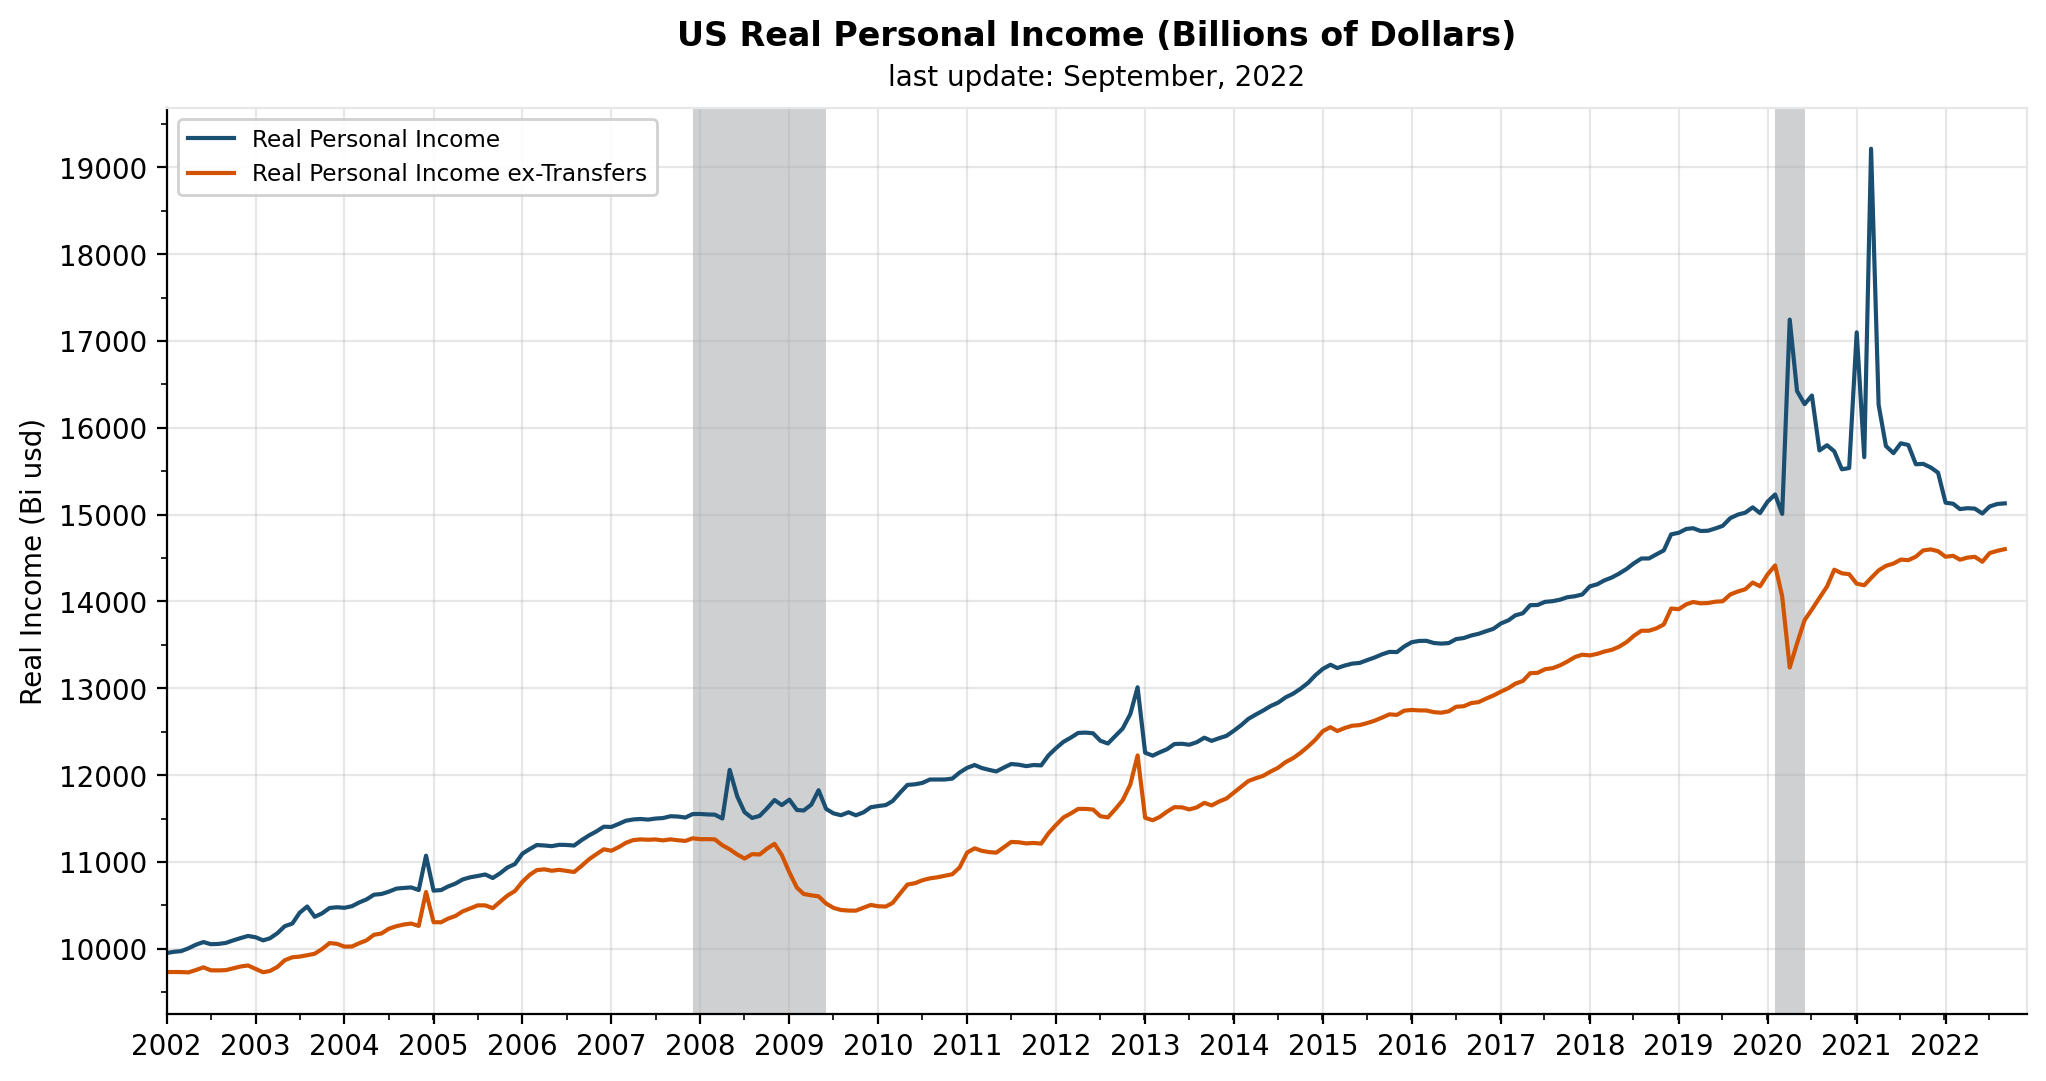

In [130]:
# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Real Personal Income","Real Personal Income ex-Transfers"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[False, False]})

# running function
fig, ax = ts_plot(df = income_level[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='US Real Personal Income (Billions of Dollars)',
                  ylab='Real Income (Bi usd)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1000, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

## Savings Rate

In [132]:
savings = income[income["LineDescription"]
                 .isin(["Personal saving as a percentage of disposable personal income"])].copy()
savings["series_id"] = (
    savings["series_id"]
    .replace(["T20600_A072RC"],
             ["Savings Rate"])
)

savings.sort_values("date").tail()

,series_id,date,value,LineDescription,METRIC_NAME,CL_UNIT
26596,Savings Rate,2022-05-01,3.6,Personal saving as a percentage of disposable ...,Ratio,Level
26597,Savings Rate,2022-06-01,3.0,Personal saving as a percentage of disposable ...,Ratio,Level
26598,Savings Rate,2022-07-01,3.5,Personal saving as a percentage of disposable ...,Ratio,Level
26599,Savings Rate,2022-08-01,3.4,Personal saving as a percentage of disposable ...,Ratio,Level
26600,Savings Rate,2022-09-01,3.1,Personal saving as a percentage of disposable ...,Ratio,Level


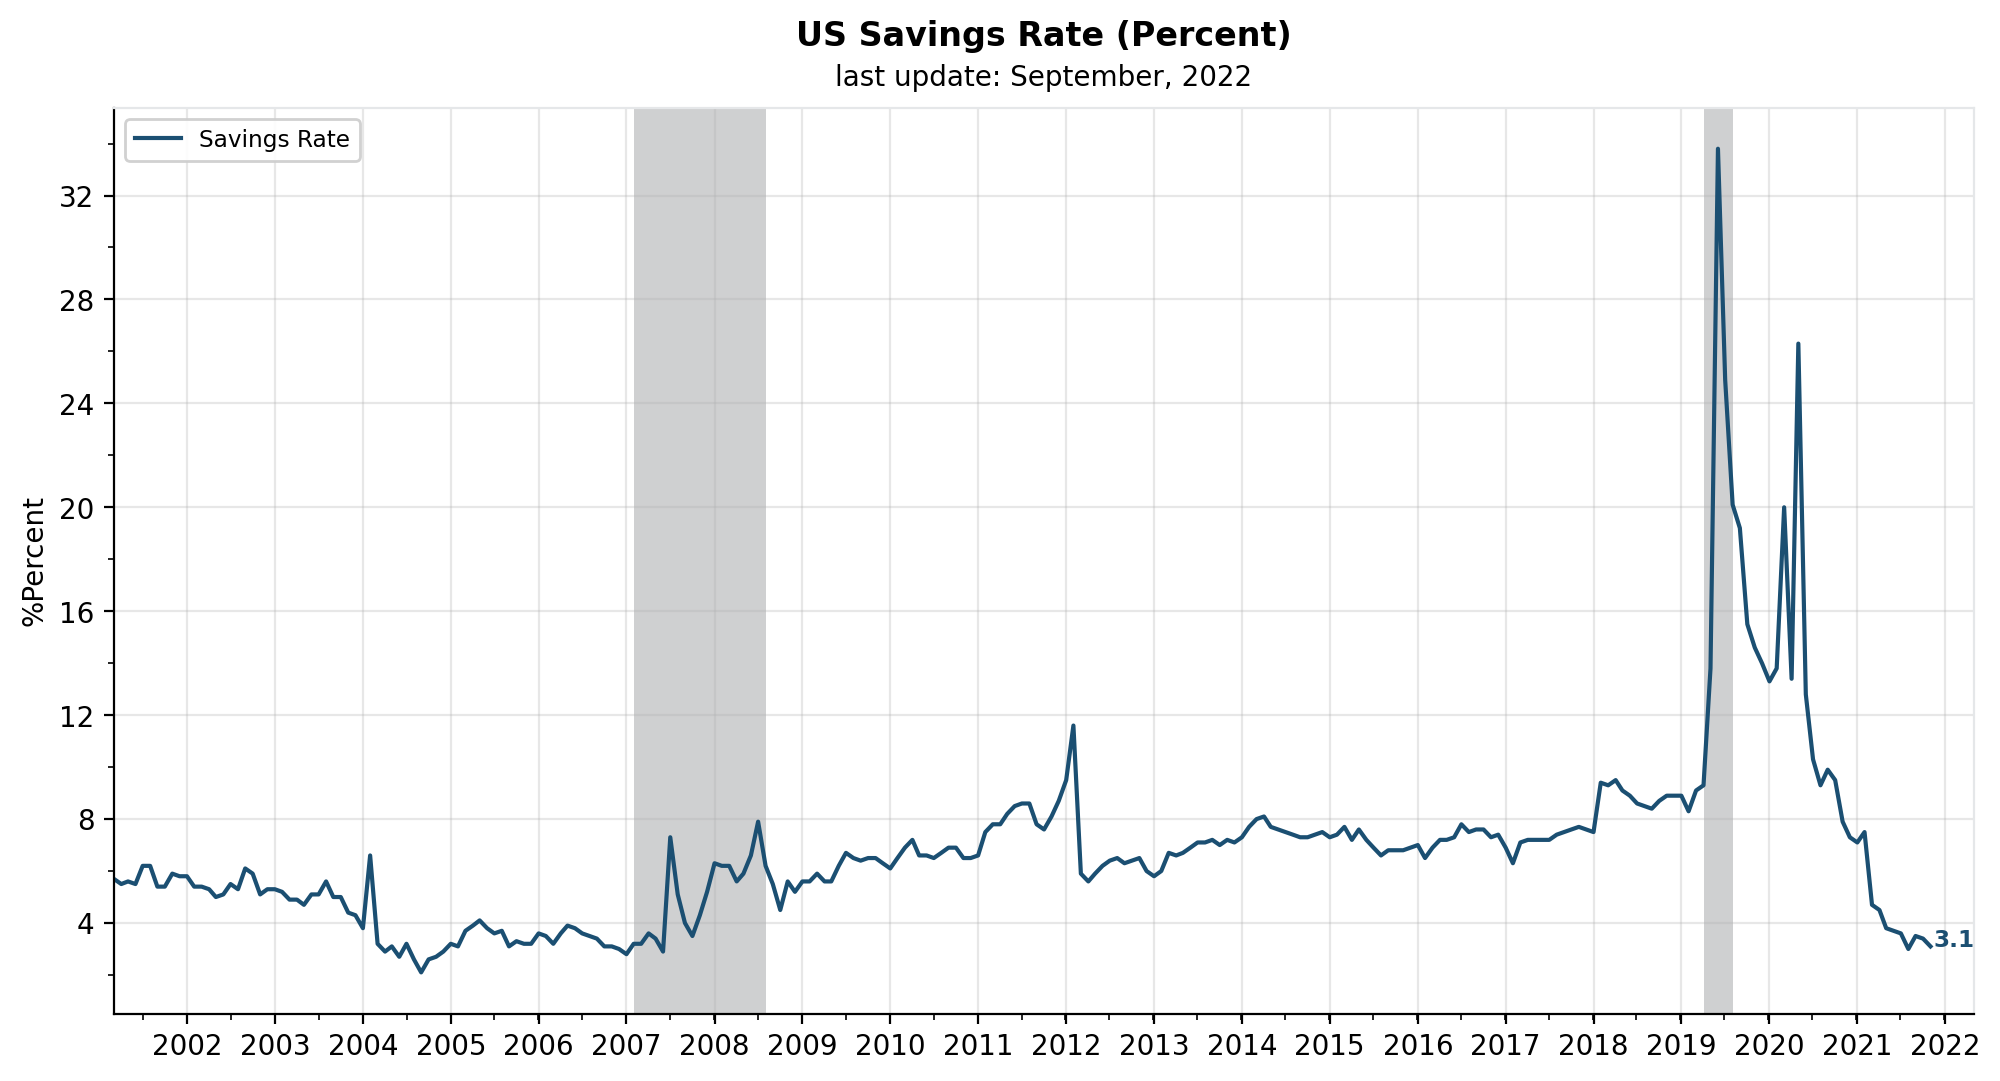

In [136]:
# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Savings Rate"],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = savings[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='US Savings Rate (Percent)',
                  ylab='%Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 4, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%Y", n=180)

plt.show()